# Hourly Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import time
import os
import sys

sys.path.append(os.path.abspath('../../LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor
    
# Dictionary to store execution times for each code block
execution_times = {}
power_stats = {}
    
# Set thread limits
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'    

In [15]:
with PowerMonitor(filename = "bulk_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    df = pd.read_csv('../../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])

    # Filter for history and the test year (2025)
    df_filtered = df[df['DATETIME'].dt.year < 2025].copy().set_index('DATETIME')
    df_2025 = df[df['DATETIME'].dt.year == 2025].copy().set_index('DATETIME')

    # Use 30 days for balance between speed and accuracy
    data_train = df_filtered['CARBON_INTENSITY'].resample('h').mean().interpolate().tail(24 * 30)
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('h').mean().interpolate()

    def create_time_features(index):
        df_feat = pd.DataFrame(index=index)
        df_feat['hour'] = index.hour / 23.0  # Normalize to [0,1]
        df_feat['day_of_week'] = index.dayofweek / 6.0
        return df_feat.values  # Only 2 features for speed

    X_train = create_time_features(data_train.index)
    X_future = create_time_features(actual_2025.index)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(data_train.values.reshape(-1, 1)).flatten()
    exec_time = time.time() - start_time
    execution_times['data processing'] = exec_time
power_stats['data processing'] = pmon.stats()


In [16]:
with PowerMonitor(filename = "bulk_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    stepwise_model = pm.auto_arima(
        y=y_train_scaled,
        X=X_train,
        seasonal=True,
        m=24,
        start_p=1, start_q=1,
        start_P=0, start_Q=0,
        max_p=3, max_q=2,
        max_P=1, max_Q=1,
        d=None, D=None,
        max_d=2, max_D=1,
        test='adf',
        seasonal_test='ocsb',
        stepwise=False,
        n_jobs=-1,
        suppress_warnings=True,
        error_action='ignore',
        information_criterion='aic',
        trace=True,
        with_intercept=False,
        maxiter=50,
        method='lbfgs'
    )
    execution_time = time.time() - start_time
    execution_times["model definition"] = execution_time
power_stats["model definition"] = pmon.stats()


Best model:  ARIMA(1,1,1)(1,0,0)[24]          
Total fit time: 20.457 seconds


In [17]:
with PowerMonitor(filename = "bulk_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    forecast_scaled = stepwise_model.predict(
        n_periods=len(actual_2025),
        X=X_future
    )

    # Inverse transform to original scale
    forecast_values = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    forecast_series = pd.Series(forecast_values, index=actual_2025.index)
    execution_time = time.time() - start_time
    execution_times["model prediction"] = execution_time
power_stats["model prediction"] = pmon.stats()


Performance Metrics:
MAE: 63.71 gCO2/kWh
RMSE: 82.23 gCO2/kWh


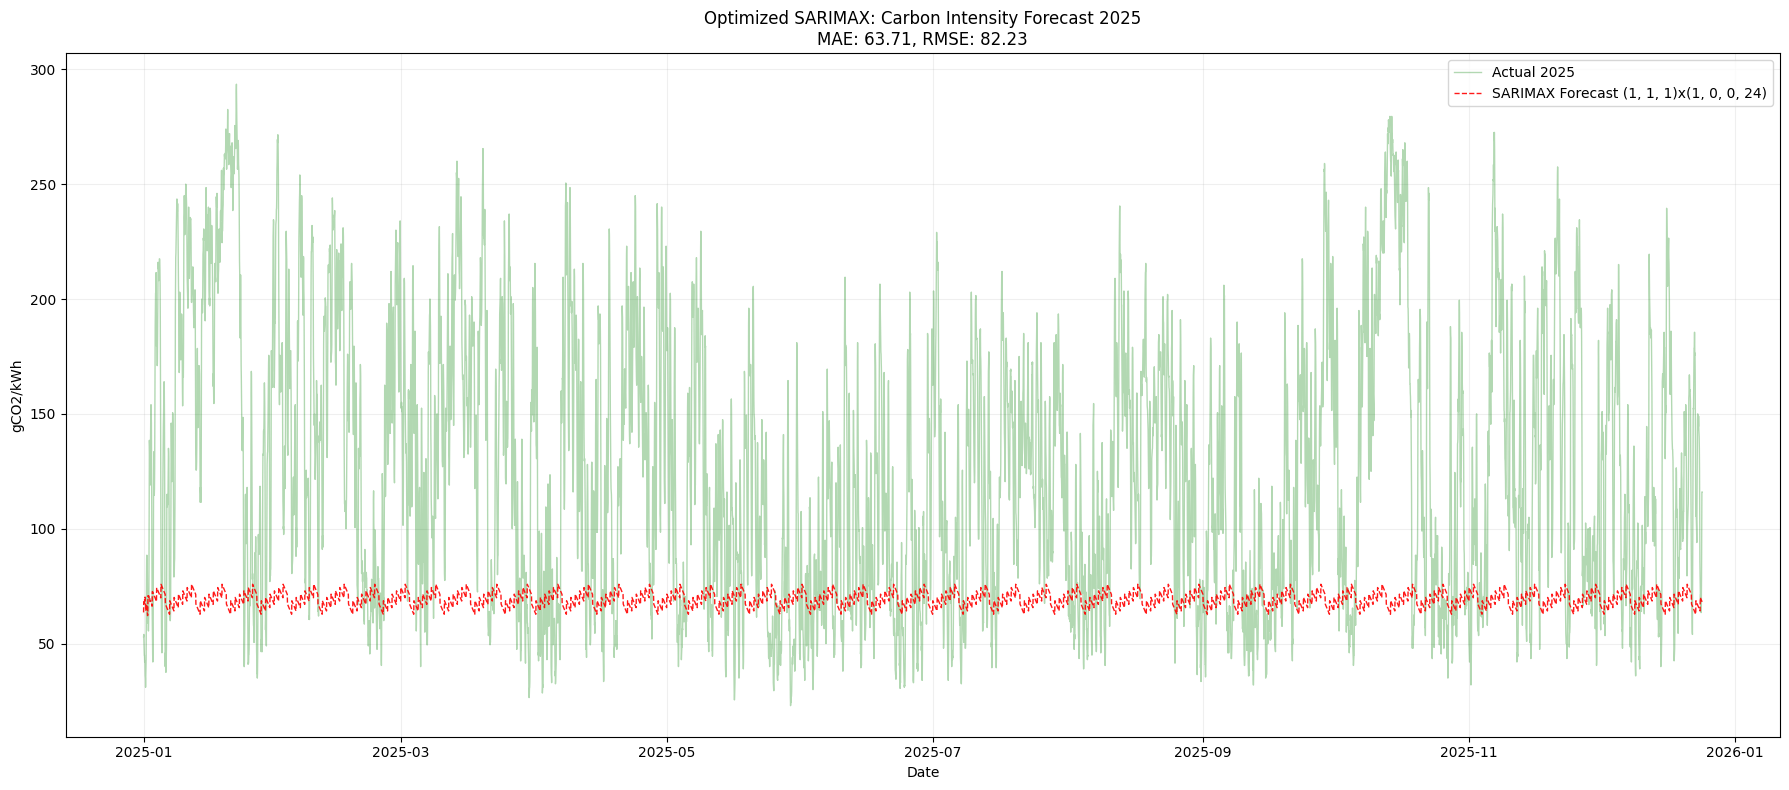

In [18]:
with PowerMonitor(filename = "bulk_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    mae = mean_absolute_error(actual_2025, forecast_series)
    rmse = np.sqrt(mean_squared_error(actual_2025, forecast_series))

    print(f"\nPerformance Metrics:")
    print(f"MAE: {mae:.2f} gCO2/kWh")
    print(f"RMSE: {rmse:.2f} gCO2/kWh")

    plt.figure(figsize=(18, 8))

    # Plot actuals
    plt.plot(actual_2025.index, actual_2025, label='Actual 2025', 
             color='green', alpha=0.3, linewidth=1)

    # Plot forecast
    plt.plot(forecast_series.index, forecast_series, 
             label=f'SARIMAX Forecast {stepwise_model.order}x{stepwise_model.seasonal_order}', 
             color='red', linestyle='--', alpha=0.9, linewidth=1)

    plt.title(f'Optimized SARIMAX: Carbon Intensity Forecast 2025\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('gCO2/kWh')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()
    execution_time = time.time() - start_time
    execution_times["plotting"] = execution_time
power_stats["plotting"] = pmon.stats()

In [19]:
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)
total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']

        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


POWER USAGE SUMMARY
data processing: {'CPU Package': {'min': 18.553590774536133, 'max': 21.91078758239746, 'avg': 20.232189178466797, 'samples': 2}, 'CPU Cores': {'min': 12.515026092529297, 'max': 13.42768669128418, 'avg': 12.971356391906738, 'samples': 2}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 2}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 2}, 'GPU Power': {'min': 0.055373385548591614, 'max': 0.055373385548591614, 'avg': 0.055373385548591614, 'samples': 2}}
model definition: {'CPU Package': {'min': 19.128816604614258, 'max': 25.893022537231445, 'avg': 22.81743621826172, 'samples': 20}, 'CPU Cores': {'min': 14.256749153137207, 'max': 26.17601203918457, 'avg': 19.42892098426819, 'samples': 20}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 20}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 20}, 'GPU Power': {'min': 0.011981680989265442, 'max': 0.04621487855911255, 'avg': 0.021902560722082853, 'samples': 20}}